# Face Detection Analysis

In [1]:
import cv2
import matplotlib.pyplot as plt
import helpers

## Dataset Analysis and Loading
This dataset has 863 images, mostly masked faces.

In [2]:
# load images and associated faces
# this takes a second since we load with cv2
imgs_with_labels = helpers.load_kaggle_863('../kaggle_dataset_863')
print(len(imgs_with_labels))

853


In [3]:
# determine dataset composition
composition = {'with_mask': 0, 'without_mask': 0, 'mask_weared_incorrect': 0}
for img in imgs_with_labels.values():
    for face in img[1].iter('object'):
        composition[face.find('name').text] += 1

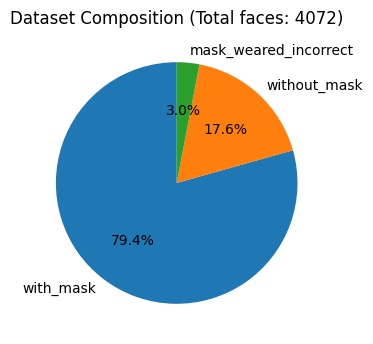

In [4]:
plt.pie(composition.values(), labels=composition.keys(), autopct='%1.1f%%', startangle=90)
plt.title(f"Dataset Composition (Total faces: {sum(composition.values())})")
plt.gcf().set_dpi(100)
plt.show()

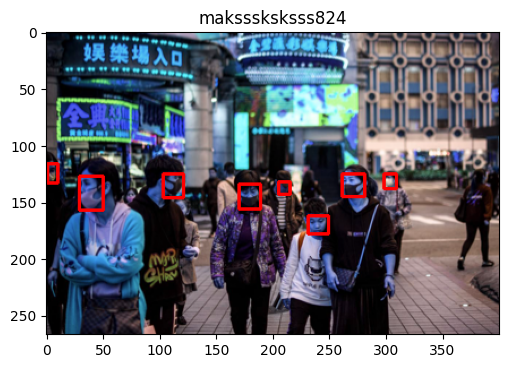

In [5]:
# display a sample
img_name, img_data = list(imgs_with_labels.items())[0]
img = img_data[0]
annotation = img_data[1]
bboxes = helpers.parse_voc_bndboxes(annotation)
for (x1,y1,x2,y2) in bboxes:
    img = cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)
plt.imshow(img)
plt.gcf().set_dpi(100)
plt.title(img_name)
plt.show()

## Non-Deep Learning
Here we investigate Viola-Jones (Haar wavelet-based, in cv2) and HOG + Linear SVM (Histogram of Directed Gradient, in face_detection) approaches for face detection in images.

### CV2 Haar Testing

In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
poorest_images = {} # images with zero detections
poor_img_threshold = 0.25
iou_threshold = 0.5
missed_pct_tracker = [] # number of missed faces per image

In [10]:
cnt = 0
for img_name, img_data in imgs_with_labels.items():
    img = img_data[0]
    annotation = img_data[1]
    gray_img = helpers.to_gray(img)
    # note to self: it appears decreasing minNeighbors improves performance by ~5% (going from 5 to 1)
    faces = face_cascade.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=5)
    labeled_faces = helpers.parse_voc_bndboxes(annotation)
    matches = 0
    matched_boxes = []
    for (x, y, w, h) in faces:
        box = (x, y, x+w, y+h)
        # for each face, check its IOU against every face label in this image
        for labeled_box in labeled_faces:
            if helpers.bb_intersection_over_union(box, labeled_box) >= iou_threshold:
                # consider this a match
                matches += 1
                matched_boxes.append(box)
# uncomment this block to display each image comparison    
#     for (x1,y1,x2,y2) in labeled_faces:
#         img = cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)
#     for (x1, y1, x2, y2) in matched_boxes:
#         img = cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)

#     cv2.imshow(img_name,img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    # disallow negatives - i.e if we generated two matches per face that is ok
    missed = max(len(labeled_faces) - matches, 0)
    missed_pct = missed/len(labeled_faces)
    missed_pct_tracker.append(missed_pct)
    if missed_pct >= poor_img_threshold:
        poorest_images[img_name] = img_data
# uncomment this to only iterate over 20 images (useful when displaying each image)
#     cnt += 1
#     if (cnt > 20): break

In [11]:
sum(missed_pct_tracker)/len(missed_pct_tracker)

0.7877119827790336

# Deep Learning
Now we look at MTCNN, RetinaFace, and the unspecified DL approach given in face_detection